In [135]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE_
from sklearn.metrics import r2_score as r2

In [86]:
class activation_functions:

  @staticmethod
  def sigmoid(arr):
    
    return np.clip(1/(1+np.exp(-arr)), 1e-9,1e9)

  @staticmethod
  def deri_sigmoid(arr):
    return arr*(1-arr)

  @staticmethod
  def relu(arr):
    arr = np.array(arr)
    return np.maximum(0,arr)

  @staticmethod
  def deri_relu(arr):
    arr = np.array(arr)
    deri = np.array([0 if ele <=0 else 1 for ele in arr])
    return deri
  
  @staticmethod
  def linear(arr):
    arr = np.array(arr)
    return arr
    
  @staticmethod
  def softmax(arr):
    arr = np.array(arr)
    return np.array([np.exp(a)/(np.exp(a).sum()) for a in arr])
 

In [87]:
#defining a layer in the neural network
class layer:
  def __init__(self, num_neurons,input_size, activation = activation_functions.sigmoid):
    self.num_neurons = num_neurons
    self.weights     = np.random.uniform(size =(input_size,num_neurons))
    self.biases      = np.random.uniform(size =(1,num_neurons))
    self.activation  = activation
    self.input_size  = input_size

  def forward(self,input):
    a = np.dot(input,self.weights)+self.biases   #try replacing with self.weights.T
    h = self.activation(a)
    return a, h

In [88]:
#various loss functions
class Loss:
  @staticmethod
  def cross_entropy(y_true, y_pred):

    y_true = np.clip(y_true,1e-9,1-1e-9)
    loss = (y_true*np.log(y_pred)).sum(axis = 1).flatten()
    
    return -1*loss
  
  @staticmethod
  def mse(y_true,y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    loss   = 0.5*np.dot((y_true-y_pred).T,(y_true-y_pred))/len(y_true)
    
    return loss.squeeze()

In [89]:
#implementation of neural network from scratch
class NeuralNetwork:
  
  def __init__(self,X,y,num_layers,num_neurons_each_layer,activation_layers, task = 'regression'):
    self.num_layers              = num_layers   #number of layers in neural network
    self.num_neurons_each_layer  = num_neurons_each_layer  # array specifying number of neurons in each layer starting from hidden layer to output layer
    self.activation_layers       = activation_layers   #activation function at each layer
    self.task                    = task               #string specifying if the neural network is used for classification or regression, for this assignment we stick only to regression  
    self.input                   = np.array(X)        #input array
    self.output                  = np.array(y)        #output array  
    self.input_shape             = self.input.shape[-1] 
    self.initialize_layers()                         

  def initialize_layers(self):  #function that initializes all layers

    self.layers = [[]]* self.num_layers

    for i in range(self.num_layers):
      if i ==0:
        self.layers[i] = layer(self.num_neurons_each_layer[i],self.input_shape,self.activation_layers[i])
      else:
        self.layers[i] = layer(self.num_neurons_each_layer[i],self.num_neurons_each_layer[i-1],self.activation_layers[i])

  def forward_propagation(self,x):  #implementation og forward propagation 
    a_k, h_k =   [[]]* self.num_layers , [[]]* self.num_layers   #h_k[-1] is output
    
    for i in range(self.num_layers):
      if i ==0:
        a_k[i], h_k[i] = self.layers[i].forward(x)   #input shape (d,)  therefore shape of a_k,h_k will be some (l,)
      else:
        a_k[i], h_k[i] = self.layers[i].forward(h_k[i-1])

    return a_k, h_k

  def backward_propagation(self,alpha = 0.01,num_iter = 1000): #implementation of backpropagation
    loss = []
    for epoch in range(num_iter):
        if self.task == 'regression':
        
          if self.activation_layers[-1] == activation_functions.sigmoid:
            a_k,h_k = self.forward_propagation(self.input)
            y_pred  = h_k[-1]
            y_true  = self.output
            grad_L_wrt_ak,e_k = [[]]*self.num_layers,[[]]*(self.num_layers)
            grad_L_wrt_wk,grad_L_wrt_bk  = [[]]*(self.num_layers), [[]]*(self.num_layers)
            e_k[self.num_layers-1] = -1*(self.output - y_pred)                   #error of output layer
            grad_L_wrt_ak[self.num_layers-1] = e_k[self.num_layers-1] * activation_functions.deri_sigmoid(y_pred)
            curr_layer = self.num_layers-1

            while curr_layer>=0:
                
                if curr_layer == 0:
                  grad_L_wrt_wk[curr_layer] = self.input.T.dot(grad_L_wrt_ak[curr_layer])    
                  grad_L_wrt_bk[curr_layer] = np.sum(grad_L_wrt_ak[curr_layer],axis=0,keepdims = True)          
                else:
                  
                  grad_L_wrt_wk[curr_layer] = h_k[curr_layer-1].T.dot(grad_L_wrt_ak[curr_layer])    
                  grad_L_wrt_bk[curr_layer] =  np.sum(grad_L_wrt_ak[curr_layer],axis=0,keepdims = True)  
                  e_k[curr_layer-1] = grad_L_wrt_ak[curr_layer].dot(self.layers[curr_layer].weights.T)              #currlayer-1
                  grad_L_wrt_ak[curr_layer-1] = e_k[curr_layer-1] * activation_functions.deri_sigmoid(h_k[curr_layer-1])

                curr_layer = curr_layer-1


            for l in range(0,self.num_layers):     #updating the weights
                self.layers[l].weights =  self.layers[l].weights - alpha*(grad_L_wrt_wk[l])
                self.layers[l].biases  =  self.layers[l].biases - alpha*(grad_L_wrt_bk[l])

          curr_loss =  1*self.calculate_loss(self.output,self.predict(self.input))  #calculate loss at each iteration
        
        loss.append(curr_loss)
    return loss  

  def calculate_loss(self,y_true,y_pred):
    return Loss.mse(y_true,y_pred)

  def predict(self,X):  #prediction on given X data matrix
    y_pred = []
    _,h_k= self.forward_propagation(X)
    
    return h_k[-1]
  def predict_test(self,X):
    y = self.predict(X)
    return np.array([[1] if i[0]>=0.5  else [0] for i in y])
    

  









**Q1** 

Write python code to implement a neural network with one hidden layer for
classifying an XOR gate. Implement the backpropagation algorithm for this
case from scratch. Use two neurons for the hidden layer.

In [90]:
#XOR gate
#Method1
X = np.array([[0,0],[0,1],[1,0],[1,1]])
Y = np.array([[0],[1],[1],[0]])            

num_iter = 10000
alpha = 0.7
l_1 = layer(2,2)     #Initializing hidden layer
l_2 =  layer(1,2)   #output layer

for i in range(num_iter):

  a_1,h_1 = l_1.forward(X)
  a_o,h_o = l_2.forward(h_1)   

  e_o = -1*(Y - h_o)                   #error of output layer
  grad_wrt_ao = e_o * activation_functions.deri_sigmoid(h_o)  #gradient with respect to preactivation 
  grad_wrt_wo = h_1.T.dot(grad_wrt_ao)      #gradient with respect to weights
  grad_wrt_bo = np.array(grad_wrt_ao).sum(axis=0) #gradients wrt to biases of output layer
   
  e_1 = grad_wrt_ao.dot(l_2.weights.T)              #currlayer-1
  grad_wrt_a1 = e_1 * activation_functions.deri_sigmoid(h_1)
  grad_wrt_w1 = X.T.dot(grad_wrt_a1)
  grad_wrt_b1 = np.array(grad_wrt_a1).sum(axis=0)
  
  #all required gradients are present, update weights 
  l_2.weights = l_2.weights -  alpha * grad_wrt_wo
  l_2.biases =l_2.biases - alpha * grad_wrt_bo
  l_1.weights = l_1.weights - alpha * grad_wrt_w1
  l_1.biases = l_1.biases - alpha * grad_wrt_b1

# Comparing target and real values
print("True output: ", Y)
print("Predicted output: ", h_o)

#A much more robust approach has been presented below

True output:  [[0]
 [1]
 [1]
 [0]]
Predicted output:  [[0.01598905]
 [0.98621731]
 [0.98621261]
 [0.01427365]]


In [91]:
#implementation of the XOR gate with generalized neural network

#Method 2
X = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([[0],[1],[1],[0]])

nn = NeuralNetwork(X,y,2,[2,1],[activation_functions.sigmoid,activation_functions.sigmoid,activation_functions.sigmoid], task = 'regression')
loss_iter  = nn.backward_propagation(0.5,10000)
print("True output: ", y)
print("Predicted output: ", nn.predict(X))

True output:  [[0]
 [1]
 [1]
 [0]]
Predicted output:  [[0.01932872]
 [0.98330873]
 [0.98329787]
 [0.01731079]]


Text(0.5, 1.0, 'Neural network implementation from scratch')

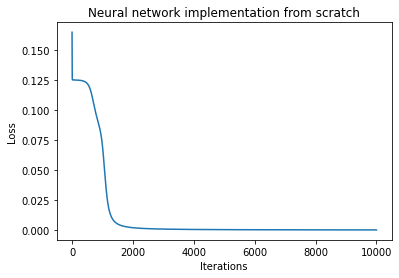

In [92]:
import matplotlib.pyplot as plt

plt.plot(np.arange(10000),loss_iter)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Neural network implementation from scratch")

**Q2**

2. Consider the Concrete Compressive Strength dataset from the first
assignment ((For the downloading of the dataset please refer to this Link

a. Implement a single layer neural network for regression. Write
backpropagation from scratch for this case in order to work for an
arbitrary number of neurons in the hidden layer. Cross check your
implementation by comparing with the Pytorch implementation of the
same.

b. Perform hyperparameter optimization to determine the appropriate
number of neurons. Do a 60-20-20 split of the dataset for training,
validation and testing.

c. How does the goodness of fit for your optimal neural network
compare with the fit obtained for linear and quadratic regression in
the earlier assignments?

d. Modify your code to accommodate an arbitrary number of layers for
a multilayer perceptron. Cross check your implementation by
comparing with the Pytorch implementation of the same. Experiment
with a few values of number of layers and comment on depth vs
width of network.


In [93]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import MinMaxScaler

In [94]:
df = pd.read_excel("Concrete_Data.xls")
df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [95]:
df.columns

Index(['Cement (component 1)(kg in a m^3 mixture)',
       'Blast Furnace Slag (component 2)(kg in a m^3 mixture)',
       'Fly Ash (component 3)(kg in a m^3 mixture)',
       'Water  (component 4)(kg in a m^3 mixture)',
       'Superplasticizer (component 5)(kg in a m^3 mixture)',
       'Coarse Aggregate  (component 6)(kg in a m^3 mixture)',
       'Fine Aggregate (component 7)(kg in a m^3 mixture)', 'Age (day)',
       'Concrete compressive strength(MPa, megapascals) '],
      dtype='object')

In [96]:
X = df.drop(columns = ['Concrete compressive strength(MPa, megapascals) '])
Y = df['Concrete compressive strength(MPa, megapascals) ']

In [97]:
X_train,X_test, Y_train, Y_test = train_test_split(X,Y,train_size = 0.6,random_state = 1)


In [98]:
#scaling the data set, ie bringing all the features to the range [0,1]
sc = MinMaxScaler()
X_train["Y"] = Y_train
X_test['Y']   = Y_test
X_train_scaled = pd.DataFrame(sc.fit_transform(X_train), columns = X_train.columns)

X_test_scaled  = pd.DataFrame(sc.transform(X_test), columns = X_test.columns)

Y_train_scaled = X_train_scaled['Y']
X_train_scaled  = X_train_scaled.drop(columns = ['Y']) 
Y_test_scaled = X_test_scaled['Y']
X_test_scaled  = X_test_scaled.drop(columns = ['Y']) 


In [99]:
#get the test and validation sets
X_val,X_pred,Y_val,Y_pred = train_test_split(X_test_scaled,Y_test_scaled,train_size = 0.5,random_state = 1)

In [124]:
def do_inverse_transform(y_pred,Y_val):
  val = X_val.copy(deep = True)
  val['Y'] = y_pred
  predictions_val = pd.DataFrame(sc.inverse_transform(val),columns = val.columns)['Y']
  val['Y'] = Y_val
  true_val = pd.DataFrame(sc.inverse_transform(val),columns = val.columns)['Y']
  return true_val, predictions_val

**Q2 a)**

In [132]:
#Neural network implementation from scratch
#the neural network contains only a single hidden layer and one output layer, making the num_layers = 2 and num_neurons_in_each_layer = [20,1]

nn_2 = NeuralNetwork(np.array(X_train_scaled),np.array(Y_train_scaled).reshape(X_train_scaled.shape[0],1),2,[20,1],[activation_functions.sigmoid, activation_functions.sigmoid], task = 'regression')
loss_iter  = nn_2.backward_propagation(0.01,10000)

R2-score:  0.809115554217472
MSE:  25.959649827755364


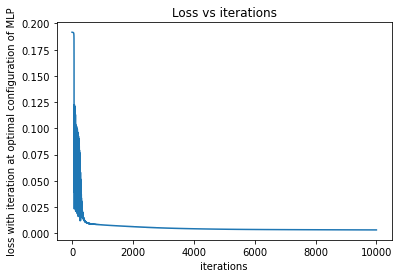

In [134]:
y_pred = nn_2.predict(np.array(X_val))
val = X_val.copy(deep = True)
val['Y'] = y_pred
predictions_val = pd.DataFrame(sc.inverse_transform(val),columns = val.columns)['Y']
val['Y'] = Y_val
true_val = pd.DataFrame(sc.inverse_transform(val),columns = val.columns)['Y']
mse = nn_2.calculate_loss(np.array(true_val).reshape(X_val.shape[0],1),np.array(predictions_val).reshape(X_val.shape[0],1))
r2score = r2(np.array(true_val).reshape(X_val.shape[0],1).squeeze(),predictions_val.squeeze())
print('R2-score: ',r2score)
print("MSE: ",mse)
plt.plot(np.arange(10000),loss_iter)
plt.title("Loss vs iterations")
plt.ylabel('loss with iteration at optimal configuration of MLP')
plt.xlabel('iterations')
plt.show()

In [125]:
#pytorch implementation of a single layer neural network
import torch
import torch.nn as nn

In [126]:
#Initialize the layers
n_input  = len(X_train_scaled.columns)
n_hidden = 20  #arbitralily chosen
n_out    = 1
batch_size = 20
learning_rate = 0.5


In [127]:
model_torch = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.Sigmoid(),
                      nn.Linear(n_hidden, n_out))
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model_torch.parameters(), lr=learning_rate)

model_torch

Sequential(
  (0): Linear(in_features=8, out_features=20, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=20, out_features=1, bias=True)
)

In [128]:
X_torch  = torch.tensor(X_train_scaled.values, dtype = torch.float32)
Y_torch  =  torch.tensor(Y_train_scaled.values, dtype = torch.float32)
loss_iter_torch = []
for epoch in range(10000):
    pred_y = torch.reshape(model_torch(X_torch), Y_torch.shape)
    loss = loss_function(pred_y, Y_torch)
    loss_iter_torch.append(loss.item())

    model_torch.zero_grad()
    loss.backward()

    optimizer.step()

MSE pytorch:  83.07001251125607
R2 score:  0.6945880740963397


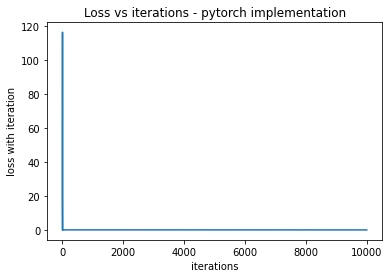

In [129]:
from sklearn.metrics import mean_squared_error as MSE_
from sklearn.metrics import r2_score as r2

X_val_torch  =  torch.tensor(X_val.values, dtype = torch.float32)
Y_val_torch  =  torch.tensor(Y_val.values, dtype = torch.float32)
y_pred =  torch.reshape(model_torch(X_val_torch), Y_val_torch.shape).detach().numpy()

true_val, predictions_val =  do_inverse_transform(y_pred,Y_val)
print("MSE pytorch: ",MSE_(true_val, predictions_val))
print("R2 score: ", r2(true_val, predictions_val))

import matplotlib.pyplot as plt
plt.plot(np.arange(10000),loss_iter_torch)
plt.title("Loss vs iterations - pytorch implementation")
plt.ylabel('loss with iteration')
plt.xlabel('iterations')
plt.show()


|Metric|Pytorch implementation|Neural network from scratch implementation|
|:-------|:-------------------:|:---------------|
|R2 score: |0.694588|0.809|
|MSE:|83.07001251125607|25.959649827755364|



Q2b) 

Hyperparameter tuning to identify the best set of number of neurons



Best learning rate:  0.01
Optimal number of hidden neurons:  20
Best validation MSE is:  0.003948283666541857


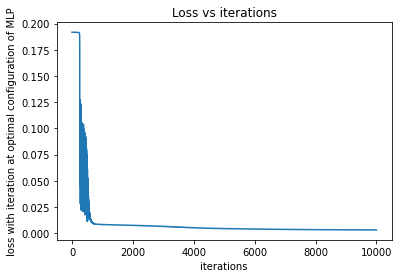

In [314]:
minmse = np.inf
best_alpha,best_num_neurons_hiddenlayer,best_mse,best_loss_iter = None,None,None,None
for num_neurons_hiddenlayer in [5,10,20,35,50,100]:
  for alpha in [0.01, 0.05, 0.1, 0.15, 0.5, 0.75]:
    nn_2 = NeuralNetwork(np.array(X_train_scaled),np.array(Y_train_scaled).reshape(X_train_scaled.shape[0],1),2,[num_neurons_hiddenlayer,1],[activation_functions.sigmoid, activation_functions.sigmoid], task = 'regression')
    loss_iter  = nn_2.backward_propagation(alpha,10000)
    y_pred = nn_2.predict(np.array(X_val))
    #calculate mean squared error
    mse = nn_2.calculate_loss(np.array(Y_val).reshape(X_val.shape[0],1),np.array(y_pred).reshape(X_val.shape[0],1))

    if mse <minmse:
      best_alpha = alpha
      best_num_neurons_hiddenlayer = num_neurons_hiddenlayer
      best_mse = mse
      best_loss_iter = loss_iter 
      minmse  =mse

print("Best learning rate: ",best_alpha)
print("Optimal number of hidden neurons: ",best_num_neurons_hiddenlayer)
print("Best validation MSE is: ",best_mse)

plt.plot(np.arange(10000),best_loss_iter)
plt.title("Loss vs iterations")
plt.ylabel('loss with iteration at optimal configuration of MLP')
plt.xlabel('iterations')
plt.show()





Therefore , the best hyperparameters found are 
Best learning rate = 0.01

Optimal number of hidden layer neurons = 20

Q2c) 
Measuring the goodness of fit in comparision with linear and quadratic models

In [306]:
#caluclating and comparing the R2 score
from sklearn.metrics import r2_score
nn_2 = NeuralNetwork(np.array(X_train_scaled),np.array(Y_train_scaled).reshape(X_train_scaled.shape[0],1),2,[best_num_neurons_hiddenlayer,1],[activation_functions.sigmoid, activation_functions.sigmoid], task = 'regression')
loss_iter  = nn_2.backward_propagation(best_alpha,10000)
y_pred = nn_2.predict(np.array(X_val))
#calculate mean squared error


In [309]:
#perform inverse transform
y_pred = nn_2.predict(np.array(X_val))
val = X_val.copy(deep = True)
val['Y'] = y_pred
predictions_val = pd.DataFrame(sc.inverse_transform(val),columns = val.columns)['Y']
val['Y'] = Y_val
true_val = pd.DataFrame(sc.inverse_transform(val),columns = val.columns)['Y']
mse = nn_2.calculate_loss(np.array(true_val).reshape(X_val.shape[0],1),np.array(predictions_val).reshape(X_val.shape[0],1))
r2score = r2_score(np.array(true_val).reshape(X_val.shape[0],1).squeeze(),predictions_val.squeeze())
print('R2-score: ',r2score)
print("MSE: ",mse)
plt.plot(np.arange(10000),best_loss_iter)
plt.title("Loss vs iterations")
plt.ylabel('loss with iteration at optimal configuration of MLP')
plt.xlabel('iterations')
plt.show()

R2-score:  0.81180167339868
MSE:  25.594346551975523


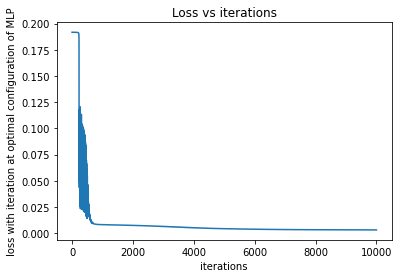

In [313]:
mse = nn_2.calculate_loss(np.array(true_val).reshape(X_val.shape[0],1),np.array(predictions_val).reshape(X_val.shape[0],1))
r2score = r2_score(np.array(true_val).reshape(X_val.shape[0],1).squeeze(),predictions_val.squeeze())
print('R2-score: ',r2score)
print("MSE: ",mse)
plt.plot(np.arange(10000),best_loss_iter)
plt.title("Loss vs iterations")
plt.ylabel('loss with iteration at optimal configuration of MLP')
plt.xlabel('iterations')
plt.show()

**Relation between linear, quadratic and Neural network model:**

**Mean Squared Error:**

|Linear Model|L2 Regularization| Quadratic model|Neural network|
|:-------|:-------------------:|:---------------|:-----------|
|96.69320796447991|96.44418569825635|61.69988804568226|25.594|


**Coefficient of determination(R2 score)**

|Linear Model|L2 Regularization| Quadratic model|Neural Network|
|:-------|:-------------------:|:---------------|:------|
|0.6547|0.6556|0.7796|0.81818|


Thus, from the above tabulation it is evident that the Neural network performed far better compared to linear and regularized models.

Q2 d)

Depth vs width of network

In [330]:
import time
max_neurons_each_layer = [20,40,60,80]
max_num_layers         = [2,4,7,10,12]

#fix number of neurons to optimal number of neurons and increase the width
minmse = np.inf
best_mse,best_num_layers,best_loss_iter = None,None,None
for num_layers in max_num_layers:
    start = time.time()
    num_neurons = np.append([[best_num_neurons_hiddenlayer]]*(num_layers-1),[1])
    nn_2 = NeuralNetwork(np.array(X_train_scaled),np.array(Y_train_scaled).reshape(X_train_scaled.shape[0],1),num_layers,num_neurons,np.array([activation_functions.sigmoid]*num_layers), task = 'regression')
    loss_iter  = nn_2.backward_propagation(best_alpha,10000)
    y_pred = nn_2.predict(np.array(X_val))
    y_pred_train = nn_2.predict(np.array(X_train_scaled))
    #calculate mean squared error
    mse = nn_2.calculate_loss(np.array(Y_val).reshape(X_val.shape[0],1),np.array(y_pred).reshape(X_val.shape[0],1))
    mse_train = nn_2.calculate_loss(np.array(Y_train_scaled).reshape(X_train_scaled.shape[0],1),np.array(y_pred_train).reshape(X_train_scaled.shape[0],1))
    if mse <minmse:
      best_mse = mse
      best_num_layers = num_layers
      best_loss_iter = loss_iter 
      minmse  =mse
    end = time.time()
    print("current depth: ",num_layers, " time of computation: ",-start+end, " MSE validation: ",mse, " MSE train: ", mse_train)
print("Optimal number of max_num_layers: ",best_num_layers)
print("Best validation MSE is: ",best_mse)



current depth:  2  time of computation:  13.405492305755615  MSE validation:  0.004359227685032982  MSE train:  0.0034201302375992926
current depth:  4  time of computation:  38.072601079940796  MSE validation:  0.11347808752062531  MSE train:  0.10864962294704542
current depth:  7  time of computation:  67.84400200843811  MSE validation:  0.18232988262711083  MSE train:  0.19179665692667328
current depth:  10  time of computation:  105.97088694572449  MSE validation:  0.11405895937939467  MSE train:  0.10921107690426207
current depth:  12  time of computation:  128.86817455291748  MSE validation:  0.11411288217785158  MSE train:  0.1092632002190915
Optimal number of max_num_layers:  2
Best validation MSE is:  0.004359227685032982


In [329]:
#fix the number of layers to best numlayers and increase the depth
import time

minmse = np.inf
best_mse,best_hidden_neurons,best_loss_iter = None,None,None

for max_neurons in max_neurons_each_layer:
    
    start = time.time()
    num_neurons = np.append([[max_neurons]]*(best_num_layers-1),[1])
    nn_2 = NeuralNetwork(np.array(X_train_scaled),np.array(Y_train_scaled).reshape(X_train_scaled.shape[0],1),best_num_layers,num_neurons,np.array([activation_functions.sigmoid]*best_num_layers), task = 'regression')
    loss_iter  = nn_2.backward_propagation(best_alpha,10000)
    y_pred = nn_2.predict(np.array(X_val))
    y_pred_train = nn_2.predict(np.array(X_train_scaled))
    #calculate mean squared error
    mse = nn_2.calculate_loss(np.array(Y_val).reshape(X_val.shape[0],1),np.array(y_pred).reshape(X_val.shape[0],1))
    mse_train = nn_2.calculate_loss(np.array(Y_train_scaled).reshape(X_train_scaled.shape[0],1),np.array(y_pred_train).reshape(X_train_scaled.shape[0],1))
    if mse <minmse:
      best_mse = mse
      best_hidden_neurons = max_neurons
      best_loss_iter = loss_iter 
      minmse  =mse
    end = time.time()
    print("current width: ",max_neurons, " time of computation: ",-start+end, " MSE validation: ",mse, " MSE train: ",mse_train)

print("Optimal number of max_neurons in each layer: ",best_hidden_neurons)
print("Best validation MSE is: ",best_mse)

current width:  20  time of computation:  9.937102556228638  MSE validation:  0.003998560813603228  MSE train:  0.0030319301266511166
current width:  40  time of computation:  15.736612558364868  MSE validation:  0.1823303940725558  MSE train:  0.19179718127623122
current width:  60  time of computation:  32.709285736083984  MSE validation:  0.18233039502707815  MSE train:  0.1917971822987391
current width:  80  time of computation:  31.848283052444458  MSE validation:  0.18233039502766232  MSE train:  0.19179718229939818
Optimal number of max_neurons in each layer:  20
Best validation MSE is:  0.003998560813603228


**General Observations on width and depth of network**
1. As depth and width of neural network increases the time of computation increases,
2. As depth and width of neural network increases, the algorithms need more and more training data to converge to a low value. The increased validation and train error indicated that data provided to the network is not sufficient and this making them less suitable for limited data scenarios
3. As the complexity of neural network increases(depth increases), the model is very likely to overfit the training data, due to low approximation error, a drop in MSE train can be observed from the above simulations, but it fails to generalize on unseen data. This is evident from relatively higher MSE validation, with increase in complexity
4. Hyperparameter tuning needs to be performed to each of these models to obtain the best performance given a configuration of the model.

**Pytorch implementation of multi layer model:**

Let us implement a pytorch model and an implementation of our model.
The results of the models are compared using MSE and r2_score



In [54]:
#Initialize the layers
n_input  = len(X_train_scaled.columns)
n_hidden = 20  #arbitralily chosen
n_out    = 1
batch_size = 20
learning_rate = 0.5
model_torch = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.Sigmoid(),
                      nn.Linear(n_hidden, n_hidden),
                      nn.Sigmoid(),
                      nn.Linear(n_hidden, n_hidden),
                      nn.Sigmoid(),
                      nn.Linear(n_hidden, n_out),
                      nn.Sigmoid())
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model_torch.parameters(), lr=learning_rate)

model_torch

Sequential(
  (0): Linear(in_features=8, out_features=20, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Sigmoid()
  (6): Linear(in_features=20, out_features=1, bias=True)
  (7): Sigmoid()
)

In [146]:
X_torch  = torch.tensor(X_train_scaled.values, dtype = torch.float32)
Y_torch  =  torch.tensor(Y_train_scaled.values, dtype = torch.float32)
loss_iter_torch = []
for epoch in range(10000):
    pred_y = torch.reshape(model_torch(X_torch), Y_torch.shape)
    loss = loss_function(pred_y, Y_torch)
    loss_iter_torch.append(loss.item())

    model_torch.zero_grad()
    loss.backward()

    optimizer.step()

In [148]:
from sklearn.metrics import mean_squared_error as MSE_
from sklearn.metrics import r2_score as r2

X_val_torch  =  torch.tensor(X_val.values, dtype = torch.float32)
Y_val_torch  =  torch.tensor(Y_val.values, dtype = torch.float32)
y_pred =  torch.reshape(model_torch(X_val_torch), Y_val_torch.shape).detach().numpy()

true_val, predictions_val =  do_inverse_transform(y_pred,Y_val)
print("MSE pytorch: ",MSE_(true_val, predictions_val))
print("R2 score: ", r2(true_val, predictions_val))

MSE pytorch:  67.18989179699098
R2 score:  0.7529722984910229


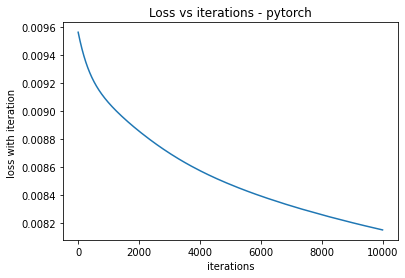

In [149]:
plt.plot(np.arange(10000),loss_iter_torch)
plt.title("Loss vs iterations - pytorch")
plt.ylabel('loss with iteration ')
plt.xlabel('iterations')
plt.show()

In [153]:
network_mlp = NeuralNetwork(np.array(X_train_scaled),np.array(Y_train_scaled).reshape(X_train_scaled.shape[0],1),4,[20,20,20,1],[activation_functions.sigmoid,activation_functions.sigmoid,activation_functions.sigmoid,activation_functions.sigmoid], task = 'regression')
loss_iter  = network_mlp.backward_propagation(0.01,10000)
y_pred = network_mlp.predict(np.array(X_val))
#print(y_pred)
val = X_val.copy(deep = True)
val['Y'] = y_pred
predictions_val = pd.DataFrame(sc.inverse_transform(val),columns = val.columns)['Y']
val['Y'] = Y_val
true_val = pd.DataFrame(sc.inverse_transform(val),columns = val.columns)['Y']
mse = network_mlp.calculate_loss(np.array(true_val).reshape(X_val.shape[0],1),np.array(predictions_val).reshape(X_val.shape[0],1))

print("MSE neural network from scratch: ",mse)


MSE neural network from scratch:  551.3541668545997
